In [1]:
import pandas as pd
import numpy as np
import arviz as az
from scipy import stats
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

Metropolis algorithm: Replicate the computations for the bioassay example of section 3.7 in BDA3 using the Metropolis algorithm. The Metropolis algorithm is described in BDA3 Chapter 11.2. More information on the bioassay data can be found in Section 3.7 in BDA3, and in Chapter 3 notes.

### 1. 

Implement the Metropolis algorithm as an R function for the bioassay data. Use the Gaussian prior as in Assignment 4, that is

[α β ] ∼ N (μ0, Σ0) , where μ0 = [0 10 ] and Σ0 = [22 12 12 102 ] .

#### a) 

Start by implementing a function called density_ratio to compute the density ratio function, r in Eq. (11.1) in BDA3. Below is an example on how the function should work. You can test the function using markmyassignment.

Hint! 

Compute with log-densities. Reasons are explained on page 261 of BDA3 and lecture video 4.1. Remember that p1/p0 = exp(log(p1) − log(p0)). For your convenience we have provided functions that will evaluate the log-likelihood for given α and β (see bioassaylp() in the aaltobda package). Notice that you still need to add the prior yourself and remember the unnormalized log posterior is simply the sum of log-likelihood and log-prior. For evaluating the log of the Gaussian prior you can use the function dmvnorm from package aaltobda.

In [2]:
#density_ratio(alpha_propose = 1.89, alpha_previous = 0.374, beta_propose = 24.76, beta_previous = 20.04, 
#              x = bioassay$x, y = bioassay$y, n = bioassay$n) 
## [1] 1.305179

#density_ratio(alpha_propose = 0.374, alpha_previous = 1.89, beta_propose = 20.04, beta_previous = 24.76, 
#               x = bioassay$x, y = bioassay$y, n = bioassay$n) 
## [1] 0.7661784

In [3]:
df=pd.read_csv('data/bioassay.csv')
df.shape

(4, 3)

In [4]:
df.head()

,x,n,y
0,-0.86,5,0
1,-0.30,5,1
2,-0.05,5,3
3,0.73,5,5


In [5]:
prior_mean=np.array([0, 10])
prior_cov=np.array([[2**2, 12],
                   [12, 10**2]])
prior_cov

array([[  4,  12],
       [ 12, 100]])

In [6]:
def bioassaylp(alpha, beta, x, y, n):
    """#' Unnormalized log-posterior for bioassay, assuming uniform prior
    #' @param alpha intercept parameter in the dose-response model (vector or single number)
    #' @param beta slope parameter in the dose-response model (vector or single number)
    #' @param x vector of doses for each observation
    #' @param y vector of number of deaths for each observation
    #' @param n vector of number of animals for each observation
    Source: https://github.com/avehtari/BDA_course_Aalto/blob/master/rpackage/R/bioassaylp.R"""
    alpha=np.array(alpha)
    beta=np.array(beta)
    t = alpha.reshape(-1,1) + np.outer(beta, x)
    et = np.exp(t)
    z = et/(1 + et)
    # ensure that log(z) and log(1-z) are computable
    eps = 1e-12
    z[z>(1-eps)] = (1-eps)
    z[z<eps] = eps
    lp = ((np.log(z).T*y[:,None]).T+ (np.log(1 - z).T*(n-y)[:,None]).T).sum(axis=1)
    return lp

In [7]:
def density_ratio(alpha_propose, alpha_previous, beta_propose, beta_previous, x, y, n):
    lp_prop=bioassaylp(alpha_propose, beta_propose, x, y, n)
    lp_prev=bioassaylp(alpha_previous, beta_previous, x, y, n)
    
    prop_prior=stats.multivariate_normal.pdf([alpha_propose, beta_propose], prior_mean, prior_cov)
    prev_prior=stats.multivariate_normal.pdf([alpha_previous, beta_previous], prior_mean, prior_cov)
    r=np.exp(lp_prop+np.log(prop_prior) - (lp_prev+np.log(prev_prior)))
    return r

In [8]:
density_ratio(alpha_propose = 1.89, alpha_previous =0.374, beta_propose = 24.76, beta_previous = 20.04, 
              x = df.x, y = df.y, n = df.n) 

C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_5020\2319008712.py:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lp = ((np.log(z).T*y[:,None]).T+ (np.log(1 - z).T*(n-y)[:,None]).T).sum(axis=1)


array([1.30517904])

In [9]:
density_ratio(alpha_propose = 0.374, alpha_previous = 1.89, beta_propose = 20.04, beta_previous = 24.76, 
               x = df.x, y = df.y, n = df.n) 

C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_5020\2319008712.py:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lp = ((np.log(z).T*y[:,None]).T+ (np.log(1 - z).T*(n-y)[:,None]).T).sum(axis=1)


array([0.76617841])

#### b) 

Now implement a function called metropolis_bioassay() which implements the Metropolis algorithm using the density_ratio(). 

Hint! Use a simple (normal) proposal distribution. Example proposals are α∗ ∼ N (αt−1, σ = 1) and β∗ ∼ N (βt−1, σ = 5). There is no need to try to find optimal proposal but test some different values for the jump scale (σ). Remember to report the one you used. Efficient proposals are dicussed in BDA3 p. 295–297 (not part of the course). In real-life a pre-run could be made with an automatic adaptive control to adapt the proposal distribution.

In [10]:
def metropolis_bioassay(alpha_start=2.5, beta_start=2.5, alpha_jump = 1, beta_jump = 5, n=1000):
    tt=[]
    alpha_=alpha_start
    beta_=beta_start
    tt.append([alpha_, beta_])

    for i in range(n):
        if i%100==0:
            print(i)
        prop_alpha=stats.norm.rvs(alpha_, alpha_jump)
        prop_beta=stats.norm.rvs(beta_, beta_jump)

        r =density_ratio(alpha_propose = prop_alpha, alpha_previous =tt[-1][0], beta_propose = prop_beta, 
                  beta_previous = tt[-1][1], x = df.x, y = df.y, n = df.n)[0]
        if r> np.random.rand():
            alpha_=prop_alpha
            beta_=prop_beta
        tt.append([alpha_, beta_])

    tt=np.array(tt)
    return tt

In [11]:
#run with 4 chains
tt1=metropolis_bioassay()

C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_5020\2319008712.py:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lp = ((np.log(z).T*y[:,None]).T+ (np.log(1 - z).T*(n-y)[:,None]).T).sum(axis=1)


0
100
200
300
400
500
600
700
800
900


In [12]:
tt2=metropolis_bioassay(alpha_start=-2.5, beta_start=2.5)

0


C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_5020\2319008712.py:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lp = ((np.log(z).T*y[:,None]).T+ (np.log(1 - z).T*(n-y)[:,None]).T).sum(axis=1)


100
200
300
400
500
600
700
800
900


In [13]:
tt3=metropolis_bioassay(alpha_start=2.5, beta_start=-2.5)

0


C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_5020\2319008712.py:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lp = ((np.log(z).T*y[:,None]).T+ (np.log(1 - z).T*(n-y)[:,None]).T).sum(axis=1)


100
200
300
400
500
600
700
800
900


In [14]:
tt4=metropolis_bioassay(alpha_start=1, beta_start=1)

0


C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_5020\2319008712.py:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lp = ((np.log(z).T*y[:,None]).T+ (np.log(1 - z).T*(n-y)[:,None]).T).sum(axis=1)


100
200
300
400
500
600
700
800
900


Text(0, 0.5, 'beta')

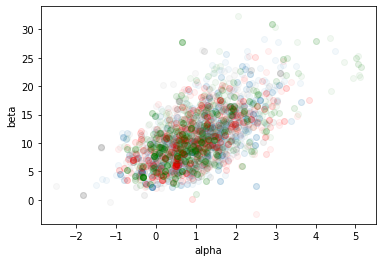

In [15]:
plt.scatter(tt1[:,0], tt1[:,1], alpha=0.05)
plt.scatter(tt2[:,0], tt2[:,1], alpha=0.05, color='grey')
plt.scatter(tt3[:,0], tt3[:,1], alpha=0.05, color='red')
plt.scatter(tt4[:,0], tt4[:,1], alpha=0.05, color='green')
plt.xlabel('alpha')
plt.ylabel('beta')

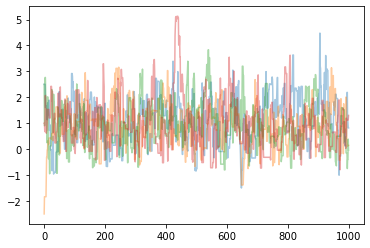

In [16]:
plt.plot(tt1[:,0], alpha=0.4)
plt.plot(tt2[:,0], alpha=0.4)
plt.plot(tt3[:,0], alpha=0.4)
plt.plot(tt4[:,0], alpha=0.4)

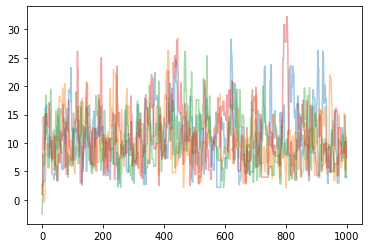

In [17]:
plt.plot(tt1[:,1], alpha=0.4)
plt.plot(tt2[:,1], alpha=0.4)
plt.plot(tt3[:,1], alpha=0.4)
plt.plot(tt4[:,1], alpha=0.4)

Text(0.5, 0, 'alpha')

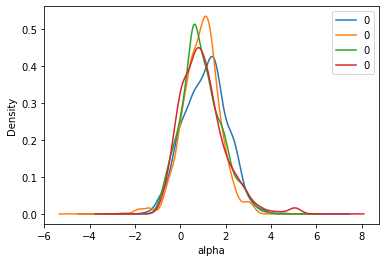

In [18]:
def plot_dens(tt1, tt2, tt3, tt4, col_i=0):
    ax=pd.DataFrame(tt1[:,col_i]).plot(kind='density')
    ax=pd.DataFrame(tt2[:,col_i]).plot(kind='density', ax=ax)
    ax=pd.DataFrame(tt3[:,col_i]).plot(kind='density', ax=ax)
    ax=pd.DataFrame(tt4[:,col_i]).plot(kind='density', ax=ax)

plot_dens(tt1, tt2, tt3, tt4)
plt.xlabel('alpha')

Text(0.5, 0, 'beta')

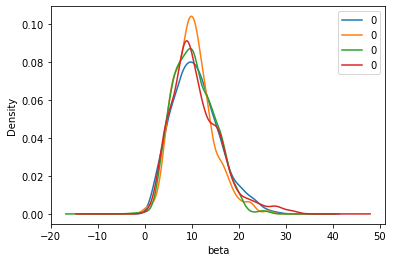

In [19]:
plot_dens(tt1, tt2, tt3, tt4, col_i=1)
plt.xlabel('beta')

### 3) 
In complex scenarios, visual assessment is not sufficient and ̂ R is a more robust indicator of convergence of the Markov chains. Use ̂ R for convergence analysis. You can either use Eq. (11.4) in BDA3 or the more recent version described in a recent article. You should specify which ̂ R you used. In R the best choice is to use function rhat_basic() from the package posterior. Remember to remove the warm-up samples before computing ̂ R. Report the ̂ R values for α and β separately. Report the values for the proposal distribution you finally used. 

a ) Describe briefly in your own words the basic idea of ̂ R and how to to interpret the obtained ̂ R values. 

b ) Tell whether you obtained good ̂ R with first try, or whether you needed to run more iterations or how did you modify the proposal distribution.

In [20]:
start_i=500
chains_alpha = np.stack([tt1[start_i:,0], tt2[start_i:,0], tt3[start_i:,0], tt4[start_i:,0]], axis=0)
chains_beta = np.stack([tt1[start_i:,1], tt2[start_i:,1], tt3[start_i:,1], tt4[start_i:,1]], axis=0)
#use arviz solution
az.rhat(chains_alpha)

1.0351943504031451

In [21]:
az.rhat(chains_beta)

1.0286105168693858

In [22]:
def rhat(chains):
    """Source: BDA ch 11.4, page 284-285"""
    #withtin variance
    n=chains.shape[1]
    s2=np.sum((chains-chains.mean(axis=1)[:,None])**2, axis=1)*(1/(n-1))
    w=np.mean(s2)
    #between variance
    m=chains.shape[0]
    chains_means=chains.mean(axis=1)
    all_mean=np.mean(chains)
    b=np.sum((chains_means-all_mean)**2)*(n/(m-1))
    #var
    var=((n-1)/n)*w+(1/n)*b
    #rhat
    rhat=np.sqrt(var/w)
    return rhat

rhat(chains_alpha)

1.0205552287105792

In [23]:
rhat(chains_beta)

1.0096018330702674

rhat in both cases is reasonably close to 1.0 (alpha on ise bigger than 1.01, but looks like it has converged)

### 4)

Plot the draws for α and β (scatter plot) and include this plot in your report. You can compare the results to Figure 3.3b in BDA3 to verify that your code gives sensible results. Notice though that the results in Figure 3.3b are generated from posterior with a uniform prior, so even when if your algorithm works perfectly, the results will look slightly different (although fairly similar).

Text(0, 0.5, 'beta')

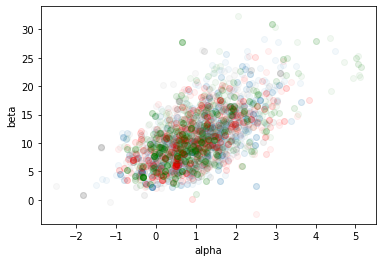

In [24]:
plt.scatter(tt1[:,0], tt1[:,1], alpha=0.05)
plt.scatter(tt2[:,0], tt2[:,1], alpha=0.05, color='grey')
plt.scatter(tt3[:,0], tt3[:,1], alpha=0.05, color='red')
plt.scatter(tt4[:,0], tt4[:,1], alpha=0.05, color='green')
plt.xlabel('alpha')
plt.ylabel('beta')

In [25]:
start_i=500
tt_stacked=np.vstack([tt1[start_i:,], tt2[start_i:,], tt3[start_i:,], tt4[start_i:,]])
tt_stacked.shape

(2004, 2)

<a list of 4 text.Text objects>

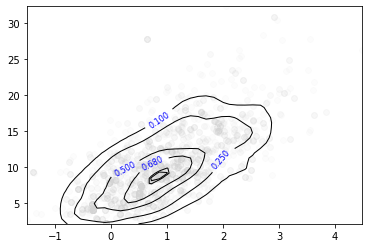

In [28]:
alpha = tt_stacked[:,0]
beta = tt_stacked[:,1]

k = gaussian_kde(np.vstack([alpha, beta]))
xi, yi = np.mgrid[alpha.min():alpha.max():alpha.size**0.5*1j, beta.min():beta.max():beta.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

#set zi to 0-1 scale
zi = (zi-zi.min())/(zi.max() - zi.min())
zi =zi.reshape(xi.shape)

#set up plot
origin = 'lower'
levels = [0,0.1,0.25,0.5,0.68, 0.95, 0.975,1]

plt.scatter(tt_stacked[:,0], tt_stacked[:,1], alpha=0.05, color='lightgrey')
CS = plt.contour(xi, yi, zi, levels = levels,
              colors=('k',),
              linewidths=(1,),
              origin=origin)

plt.clabel(CS, fmt='%.3f', colors='b', fontsize=8)